In [1]:
%pip install numpy matplotlib scapy[basic] tqdm

Note: you may need to restart the kernel to use updated packages.


In [2]:
from tqdm import tqdm
from scapy.all import PcapReader


def accumulate(file, *accumulators):
    with PcapReader(file) as reader, tqdm(unit='packets', desc=file) as pbar:
        for packet in reader:
            for accumulator in accumulators:
                accumulator(packet)
            pbar.update()
        return accumulators

In [3]:
import random
import numpy as np
from scapy.layers.dot11 import Dot11ProbeReq


class ProbeReqAcc(list):
    TYPE = ('timestamp', np.float), ('mac', np.string_, 17)
    
    def __call__(self, packet):
        if packet.haslayer(Dot11ProbeReq):
            values = packet.time, packet.addr2
            self.append(values)
            
    def as_numpy_array(self):
        return np.array(self, dtype=np.dtype([*self.TYPE]))


class RandProbeReqSampler(list):
    PROBABILITY = 0.001
    
    def __call__(self, packet):
        if packet.haslayer(Dot11ProbeReq) and random.random() <= self.PROBABILITY:
            self.append(packet)

In [5]:
commute_16122019, commute_16122019_samples = accumulate('../probes/capture-0-a4.pcap', ProbeReqAcc(), RandProbeReqSampler())
commute_17122019, commute_17122019_samples = accumulate('../probes/capture-1-a4.pcap', ProbeReqAcc(), RandProbeReqSampler())
commute_18122019, commute_18122019_samples = accumulate('../probes/capture-2-a4.pcap', ProbeReqAcc(), RandProbeReqSampler())

../probes/capture-0-a4.pcap: 57279packets [01:50, 516.65packets/s]
../probes/capture-1-a4.pcap: 67268packets [02:15, 495.47packets/s]
../probes/capture-2-a4.pcap: 59223packets [01:57, 503.44packets/s]


In [7]:
def duration(data):
    timestamps = data[:]['timestamp']
    return np.amax(timestamps) - np.amin(timestamps)


durations = {'commute_16122019': duration(commute_16122019.as_numpy_array()),
             'commute_17122019': duration(commute_17122019.as_numpy_array()),
             'commute_18122019': duration(commute_18122019.as_numpy_array())
            }

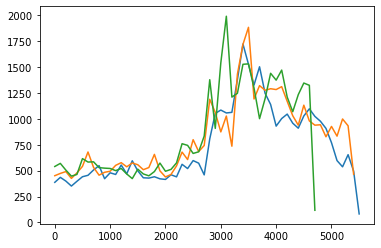

In [29]:
%matplotlib inline
import math
import matplotlib
import matplotlib.pyplot as plt
    
def plot_packets_per_time_interval(commute):
    sampling_interval = 100

    number_of_buckets = math.ceil(duration(commute.as_numpy_array()) / sampling_interval)

    result = np.zeros(number_of_buckets)
    timestamps = commute.as_numpy_array()[:]['timestamp']
    timestamp_min = np.amin(timestamps)
    for timestamp in timestamps:
        result[math.floor((timestamp - timestamp_min) / sampling_interval)] += 1

    x_axis = np.arange(0, (number_of_buckets) * sampling_interval, sampling_interval)

    plt.plot(x_axis, result)
    
plot_packets_per_time_interval(commute_16122019)
plot_packets_per_time_interval(commute_17122019)
plot_packets_per_time_interval(commute_18122019)

In [15]:
commute_16122019_samples[0].show()


###[ RadioTap dummy ]### 
  version   = 0
  pad       = 0
  len       = 18
  present   = Flags+Rate+Channel+dBm_AntSignal+Antenna+RXFlags
  Flags     = 
  Rate      = 11
  ChannelFrequency= 2462
  ChannelFlags= CCK+2GHz
  dBm_AntSignal= -56dBm
  Antenna   = 1
  RXFlags   = 
  notdecoded= ''
###[ 802.11 ]### 
     subtype   = 4
     type      = Management
     proto     = 0
     FCfield   = 
     ID        = 0
     addr1     = ff:ff:ff:ff:ff:ff
     addr2     = 66:3f:7f:e8:39:1b
     addr3     = ff:ff:ff:ff:ff:ff
     SC        = 6480
###[ 802.11 Probe Request ]### 
###[ 802.11 Information Element ]### 
           ID        = SSID
           len       = 0
           info      = ''
###[ 802.11 Rates ]### 
           ID        = 1
           len       = 4
           rates     = [0x2, 0x4, 0xb, 0x16]
###[ 802.11 Information Element ]### 
           ID        = ESRates
           len       = 8
           info      = '\x0c\x12\x18$0H`l'
###[ 802.11 Information Element ]### 
           ID    